In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np



db = mysql.connector.connect(host = "localhost",
                             username ="root",
                             password="Bhumi@1425",
                             database="ecommerce")
cur = db.cursor()


# List all unique cities where customers are located.

In [48]:
query = """SELECT DISTINCT customer_city FROM customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["customer_city"])  # Specify the column name
df.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [10]:
query = """SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

data
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# Find the total sales per category.

In [22]:
query = """SELECT upper (products.product_category) AS category,
                  ROUND(SUM(payments.payment_value),2) AS sales
           FROM products 
           JOIN order_items ON products.product_id = order_items.product_id
           JOIN payments ON payments.order_id = order_items.order_id
           GROUP BY category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["category", "sales"])

df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


 # Calculate the percentage of orders that were paid in installments.

In [31]:
query = """SELECT (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END))/ count(*)*100 FROM payments"""

cur.execute(query)

data = cur.fetchall()
"the percentage of orders that were paid in installments is ", data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state.

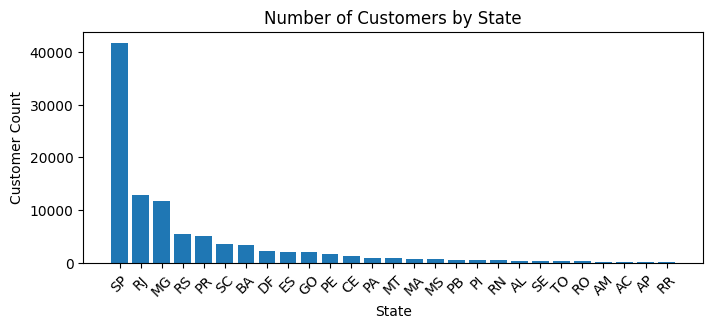

In [46]:
query = """SELECT customer_state, COUNT(customer_id)
FROM customers
GROUP BY customer_state"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["state", "customer_count"])
df = df.sort_values(by="customer_count", ascending=False)  # Sort by customer_count in descending order

plt.figure(figsize=(8,3))
plt.bar(df["state"], df["customer_count"])
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.title("Number of Customers by State")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


 # Calculate the number of orders per month in 2018.

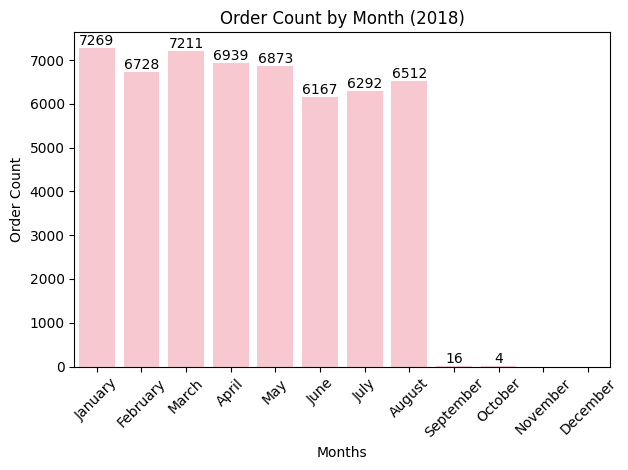

In [60]:
query = """
SELECT MONTHNAME(order_purchase_timestamp) AS months, COUNT(order_id) AS order_count
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY months
ORDER BY FIELD(months, 
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December');
"""

cur.execute(query)

data = cur.fetchall()

# Correct DataFrame initialization
df = pd.DataFrame(data, columns=["months", "order_count"])

# Define the correct month order
o = ["January", "February", "March", "April", "May", "June", 
     "July", "August", "September", "October", "November", "December"]

# Create a barplot
ax = sns.barplot(x="months", y="order_count", data=df, order=o, color = "pink")
plt.xlabel("Months")
plt.ylabel("Order Count")
plt.title("Order Count by Month (2018)")
plt.xticks(rotation=45)  # Rotate month names for better readability

# Add bar labels
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()  # Adjust layout for better fit
plt.show()

# Find the average number of products per order, grouped by customer city.

In [69]:
query = """
WITH count_per_order AS (
    SELECT 
        orders.order_id, 
        orders.customer_id, 
        COUNT(order_items.order_id) AS item_count
    FROM ecommerce.orders
    JOIN order_items 
    ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)
SELECT 
    customers.customer_city, 
   round( AVG(count_per_order.item_count),2) AS avg_items_per_order
FROM customers
JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["customer_city", "average_orders"])
df.head(10)

,customer_city,average_orders
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
5,rio de janeiro,1.15
6,mario campos,1.33
7,guariba,1.00
8,cuiaba,1.20
9,franca,1.25


 # Calculate the percentage of total revenue contributed by each product category.

In [73]:
query =""" SELECT
    UPPER(products.product_category) AS category,
    round((SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100 ,2) AS sales_percentage
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category order by sales_percentage desc		
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["category", "sales_percentage"])
df.head(5)


,category,sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


 # Identify the correlation between product price and the number of times a product has been purchased.

In [80]:
query = """SELECT products.product_category,
count(order_items.product_id),	
ROUND(AVG(order_items.price), 2) AS avg_price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["category", "order_count", "price"])
arr1 = df["order_count"]
arr2 = df["price"]

# Extracting the two columns for correlation
arr1 = df["order_count"]
arr2 = df["price"]

# Compute the correlation coefficient
correlation_matrix = np.corrcoef(arr1, arr2)

# Display the correlation coefficient
print(correlation_matrix)

[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


# Calculate the total revenue generated by each seller, and rank them by revenue.

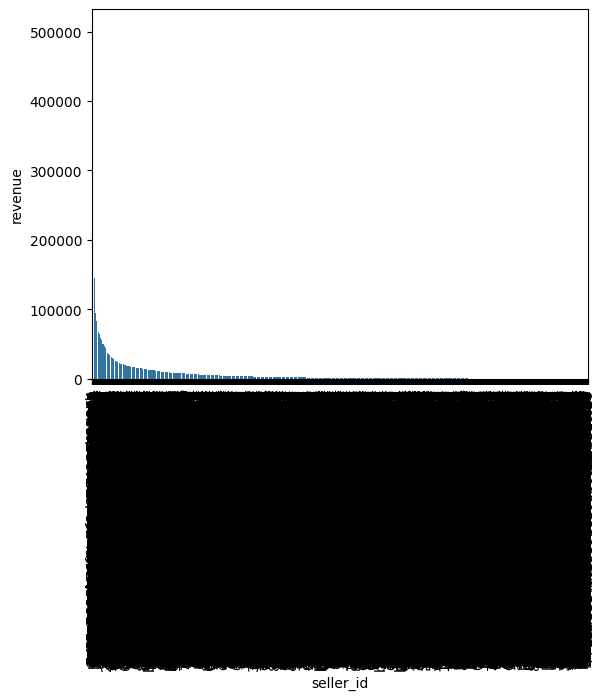

In [96]:
query ="""select *, dense_rank() over (order by revenue desc) 
from
(select order_items.seller_id, sum(payments.payment_value)
revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) AS a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["seller_id", "revenue", "rank"])
df.head(10)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
sns.barplot(x= "seller_id", y = "revenue", data = df)
plt.show()